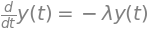

In [1]:
import sympy as sym
sym.init_printing()
t, l = sym.symbols('t lambda')
y = sym.Function('y')(t)
dydt = y.diff(t)
expr = sym.Eq(dydt, -l*y)
expr

In [2]:
sym.dsolve(expr)

In [3]:
def vdp(y, t, mu):
    return [
        y[1],
        mu*(1-y[0]**2)*y[1] - y[0]
    ]

In [5]:
import numpy as np
def euler_fw(rhs, y0, tout, params):
    y0 = np.atleast_1d(np.asarray(y0, dtype=np.float64))
    dydt = np.empty_like(y0)
    yout = np.zeros((len(tout), len(y0)))
    yout[0] = y0
    t_old = tout[0]
    for i, t in enumerate(tout[1:], 1):
        dydt[:] = rhs(yout[i-1], t, *params)
        h = t - t_old
        yout[i] = yout[i-1] + dydt*h
        t_old = t
    return yout


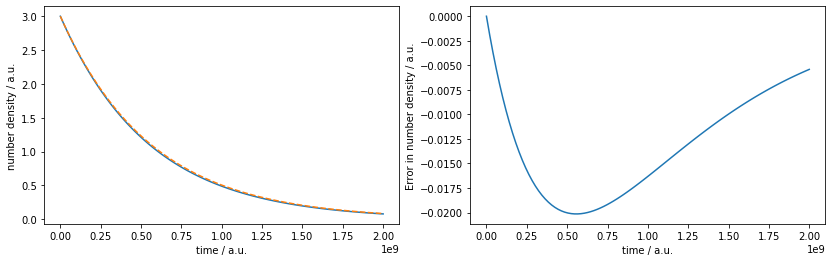

In [6]:
def rhs(y, t, decay_constant):
    return -decay_constant*y  # the rate does not depend on time ("t")
tout = np.linspace(0, 2e9, 100)
y0 = 3
params = (1.78e-9,)  # 1 parameter, decay constant of tritium
yout = euler_fw(rhs, y0, tout, params)


import matplotlib.pyplot as plt
%matplotlib inline

def my_plot(tout, yout, params, xlbl='time / a.u.', ylabel=None, analytic=None):
    fig, axes = plt.subplots(1, 2 if analytic else 1, figsize=(14, 4))
    axes = np.atleast_1d(axes)
    for i in range(yout.shape[1]):
        axes[0].plot(tout, yout[:, i], label='y%d' % i)
    if ylabel:
        axes[0].set_ylabel(ylabel)
    for ax in axes:
        ax.set_xlabel(xlbl)
    if analytic:
        axes[0].plot(tout, analytic(tout, yout, params), '--')
        axes[1].plot(tout, yout[:, 0] - yout[0]*np.exp(-params[0]*(tout-tout[0])))
        if ylabel:
            axes[1].set_ylabel('Error in ' + ylabel)
def analytic(tout, yout, params):
    return yout[0, 0]*np.exp(-params[0]*tout)
my_plot(tout, yout, params, analytic=analytic, ylabel='number density / a.u.')

Number of function evaluations: 95


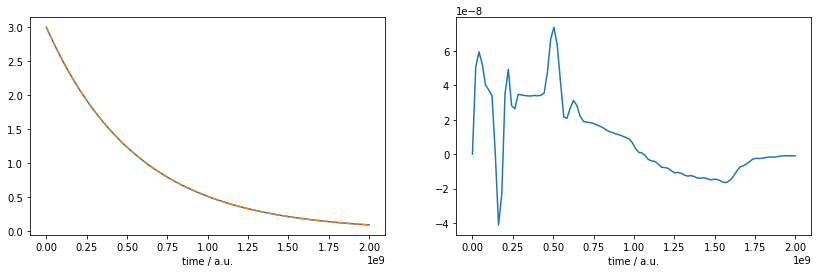

In [7]:
from scipy.integrate import odeint
yout, info = odeint(rhs, y0, tout, params, full_output=True)
my_plot(tout, yout, params, analytic=analytic)
print("Number of function evaluations: %d" % info['nfe'][-1])

In [8]:

tout = np.linspace(0, 200, 1024)
y_init, params = [1, 0], (17,)
y_euler = euler_fw(vdp, y_init, tout, params)  # never mind the warnings emitted here...

/Users/mccanndahl/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/Users/mccanndahl/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in add
  # This is added back by InteractiveShellApp.init_path()


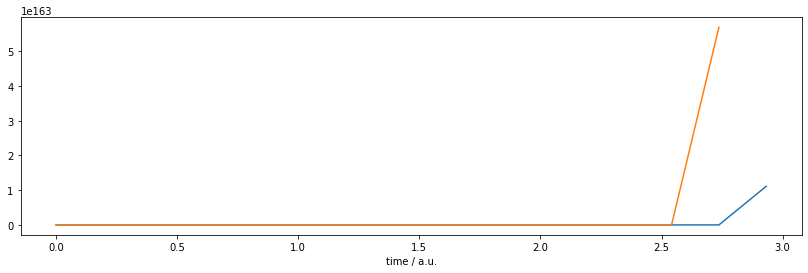

In [9]:
my_plot(tout, y_euler, params)

Number of function evaluations: 9150, number of Jacobian evaluations: 206


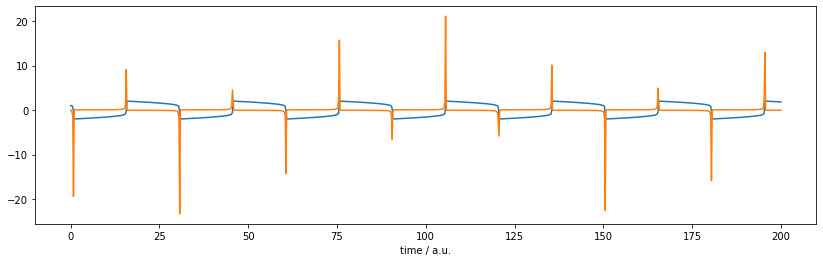

In [10]:
y_odeint, info = odeint(vdp, y_init, tout, params, full_output=True)
print("Number of function evaluations: %d, number of Jacobian evaluations: %d" % (info['nfe'][-1], info['nje'][-1]))
my_plot(tout, y_odeint, params)

Number of function evaluations: 8590, number of Jacobian evaluations: 202


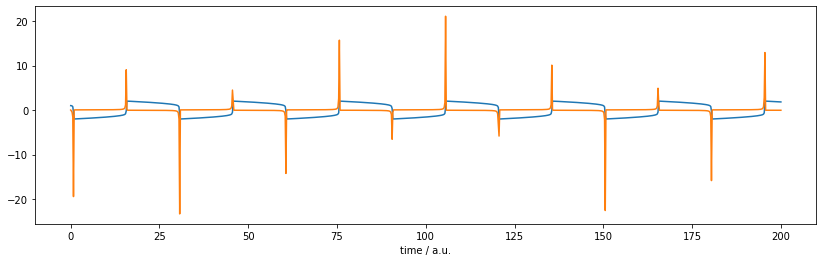

In [12]:
# %exercise exercise_jac_func.py
def J_func(y, t, mu):
    return np.array([
        [0, 1],
        [-1-2*mu*y[0]*y[1], mu*(1-y[0]**2)]  # EXERCISE: -1-2*mu*y[0]*y[1]
    ])
J_func(y_init, tout[0], params[0])

y_odeint, info = odeint(vdp, y_init, tout, params, full_output=True, Dfun=J_func)
my_plot(tout, y_odeint, params)
print("Number of function evaluations: %d, number of Jacobian evaluations: %d" % (info['nfe'][-1], info['nje'][-1]))

In [13]:
y = y0, y1 = sym.symbols('y0 y1')
mu = sym.symbols('mu')
J = sym.Matrix(vdp(y, None, mu)).jacobian(y)
J_func = sym.lambdify((y, t, mu), J)
J

⎡      0              1     ⎤
⎢                           ⎥
⎢                  ⎛      2⎞⎥
⎣-2⋅μ⋅y₀⋅y₁ - 1  μ⋅⎝1 - y₀ ⎠⎦

Number of function evaluations: 8590, number of Jacobian evaluations: 202


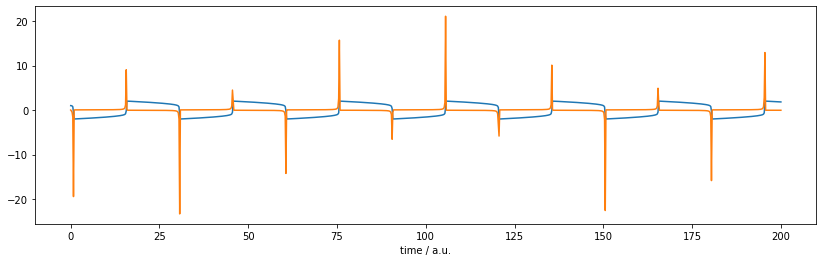

In [14]:
# McCanns code. Lets see if we can interpret this.


In [34]:
import sympy as sym
from sympy.plotting import plot
sym.init_printing()
t, l = sym.symbols('t lambda')
C1, C2 = sym.symbols('C1 C2')
y = sym.Function('y')(t)
dydt = y.diff(t)
expr = sym.Eq(dydt, -l*y)
expr
kathy = sym.dsolve(expr)
abby = kathy.rhs
print(abby)
abby = abby.subs(l,5)
abby = abby.subs(C1,5)
print(abby)

C1*exp(-lambda*t)
5*exp(-5*t)


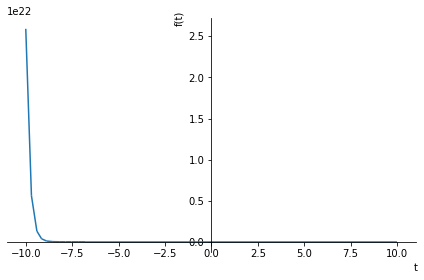

In [35]:
p1 = plot(abby, show=True)